## Aspergillus

This analysis solely focuses on the presence of Apergillus. Initially we will look at pwCF ID 676138 because they have Aspergillus infections, and then we expand to all people. There is a summary write up available too.

## Import the libraries

In [19]:
import os
import sys
from socket import gethostname

hostname = gethostname()

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, roc_curve, auc

from scipy.stats import linregress


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText python-docx
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'

from adjustText import adjust_text

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
import cf_analysis_lib

In [20]:
sequence_type = "MGI"
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "species"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=True)

merged = df.join(metadata, how='inner')

print(f"The merged Data Frame has shape: {merged.shape}")

Read 127 samples and 769 subsystems


The merged Data Frame has shape: (127, 32306)


Read 127 samples and 31371 species
Read 127 samples and 166 metadata columns


## Inititally focus on one pwCF who has Aspergillus.

In [22]:
aspergs = []
for c in merged.columns:
    if 'aspergill' in c.lower(): 
        aspergs.append(c)

igs = ['IgE', 'Spec IgE', 'Spec IgG', 'Precipitins', 'FEV1/best FEV1']
res = merged[merged['pwCF_ID']==676138].loc[:,['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + aspergs].sort_values(by='Sample date')
res

,pwCF_ID,Sample date,Sum of antifungals,IgE,Spec IgE,Spec IgG,Precipitins,FEV1/best FEV1,Aspergillus aculeatinus,Aspergillus alliaceus,...,CS_Aspergillus fumigatus,CS_Aspergillus flavus,CS_Aspergillus nidulans,CS_Aspergillus niger,CS_Aspergillus terreus,P12M_6_Aspergillus,N12M_Aspergillus fumigatus,O_Aspergillus Flavus,O_Aspergillus niger,O_Aspergillus terreus
676138_20171001_S,676138,2017-10-01,0,NaN,NaN,NaN,NaN,0.964286,0.0,0.0,...,0,0,0,0,0,1.0,1.0,0,0,0
676138_20171009_S,676138,2017-10-09,0,NaN,NaN,NaN,NaN,0.964286,0.0,0.0,...,1,0,0,0,0,1.0,1.0,0,0,0
676138_20180130_S,676138,2018-01-30,2,NaN,NaN,NaN,NaN,0.928571,0.0,0.0,...,0,0,0,0,0,1.0,1.0,0,0,0
676138_20180323_S,676138,2018-03-23,1,992.0,36.0,NaN,2.0,0.857143,0.0,0.0,...,1,0,0,0,0,1.0,1.0,0,0,0
676138_20180405_S,676138,2018-04-05,2,NaN,NaN,NaN,NaN,0.892857,0.0,0.0,...,0,0,0,0,0,1.0,1.0,0,0,0


In [23]:
todrop = []
for c in df.columns:
    if 'aspergill' in c.lower() and res[c].sum() == 0:
        todrop.append(c)
res = res.drop(todrop, axis=1)

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(res)

,pwCF_ID,Sample date,Sum of antifungals,IgE,Spec IgE,Spec IgG,Precipitins,FEV1/best FEV1,Aspergillus candidus,Aspergillus fischeri,Aspergillus fumigatus,Aspergillus mulundensis,Aspergillus sclerotialis,Aspergillus turcosus,Aspergillus udagawae,CS_Aspergillus fumigatus,CS_Aspergillus flavus,CS_Aspergillus nidulans,CS_Aspergillus niger,CS_Aspergillus terreus,P12M_6_Aspergillus,N12M_Aspergillus fumigatus,O_Aspergillus Flavus,O_Aspergillus niger,O_Aspergillus terreus
676138_20171001_S,676138,2017-10-01,0,NaN,NaN,NaN,NaN,0.964286,0.0000,0.000000,94.946140,0.000000,0.0000,0.000000,1.758262,0,0,0,0,0,1.0,1.0,0,0,0
676138_20171009_S,676138,2017-10-09,0,NaN,NaN,NaN,NaN,0.964286,0.0000,0.409186,2.864305,0.000000,0.0000,0.000000,0.000000,1,0,0,0,0,1.0,1.0,0,0,0
676138_20180130_S,676138,2018-01-30,2,NaN,NaN,NaN,NaN,0.928571,0.0000,0.000000,18.365701,0.282549,0.0000,0.000000,0.000000,0,0,0,0,0,1.0,1.0,0,0,0
676138_20180323_S,676138,2018-03-23,1,992.0,36.0,NaN,2.0,0.857143,0.0000,0.000000,30.436793,0.000000,0.0000,0.000000,0.000000,1,0,0,0,0,1.0,1.0,0,0,0
676138_20180405_S,676138,2018-04-05,2,NaN,NaN,NaN,NaN,0.892857,0.1742,0.000000,1.741998,0.000000,0.1742,0.522599,0.000000,0,0,0,0,0,1.0,1.0,0,0,0


### Write the data frame out to a docx file for inclusion in the SOM

In [25]:
cf_analysis_lib.pd2docx(res, "data/Aspergillus_676138.docx")

# What about other people who have Aspergillus?

In [26]:
res = merged[((merged['CS_Aspergillus fumigatus'] == 1) | (merged['Aspergillus fumigatus'] > 0))].loc[:,['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + aspergs].sort_values(by='Sample date')
todrop = []
for c in df.columns:
    if 'aspergill' in c.lower() and res[c].sum() == 0:
        todrop.append(c)
res = res.drop(todrop, axis=1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(res)

,pwCF_ID,Sample date,Sum of antifungals,IgE,Spec IgE,Spec IgG,Precipitins,FEV1/best FEV1,Aspergillus aculeatinus,Aspergillus alliaceus,Aspergillus arachidicola,Aspergillus avenaceus,Aspergillus awamori,Aspergillus brasiliensis,Aspergillus burnettii,Aspergillus calidoustus,Aspergillus campestris,Aspergillus candidus,Aspergillus carbonarius,Aspergillus chevalieri,Aspergillus cristatus,Aspergillus ellipticus,Aspergillus eucalypticola,Aspergillus felis,Aspergillus fijiensis,Aspergillus fischeri,Aspergillus flavus,Aspergillus fumigatiaffinis,Aspergillus fumigatus,Aspergillus hiratsukae,Aspergillus homomorphus,Aspergillus lentulus,Aspergillus melleus,Aspergillus mulundensis,Aspergillus nidulans,Aspergillus niger,Aspergillus nomiae,Aspergillus novofumigatus,Aspergillus oryzae,Aspergillus parasiticus,Aspergillus pseudocaelatus,Aspergillus pseudonomiae,Aspergillus ruber,Aspergillus sclerotialis,Aspergillus sclerotiicarbonarius,Aspergillus sp. HF37,Aspergillus taichungensis,Aspergillus tamarii,Aspergillus tanneri,Aspergillus terreus,Aspergillus thermomutatus,Aspergillus turcosus,Aspergillus udagawae,Aspergillus ustus,Aspergillus uvarum,Aspergillus versicolor,Aspergillus viridinutans,Aspergillus welwitschiae,Aspergillus wentii,CS_Aspergillus fumigatus,CS_Aspergillus flavus,CS_Aspergillus nidulans,CS_Aspergillus niger,CS_Aspergillus terreus,P12M_6_Aspergillus,N12M_Aspergillus fumigatus,O_Aspergillus Flavus,O_Aspergillus niger,O_Aspergillus terreus
698564_20171001_S,698564,2017-10-01,0,891.0,52.00,NaN,2.0,0.842857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,30.415938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.415938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.415938,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0.0,0.0,0,0,0
676138_20171001_S,676138,2017-10-01,0,NaN,NaN,NaN,NaN,0.964286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.946140,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.758262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,1.0,1.0,0,0,0
670829_20171001_S,670829,2017-10-01,0,NaN,NaN,NaN,NaN,0.792000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,2.690135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.690135,0.000000,0.000000,2.690135,0.000000,0.000000,1.345068,0.000000,0.000000,0.000000,2.690135,0.000000,0.000000,0.000000,0.000000,1.345068,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.690135,0.000000,0.000000,0.000000,0.000000,1,1,0,0,0,1.0,1.0,1,0,0
676138_20171009_S,676138,2017-10-09,0,NaN,NaN,NaN,NaN,0.964286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.409186,0.000000,0.000000,2.864305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0,1.0,1.0,0,0,0
1565754_20171128_S,1565754,2017-11-28,0,NaN,NaN,NaN,NaN,0.961538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.499428,0.00

In [28]:
ressmall = res.loc[:,['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + ['CS_Aspergillus fumigatus', 'Aspergillus fumigatus', 'P12M_6_Aspergillus', 'N12M_Aspergillus fumigatus']]
ressmall = ressmall.sort_values(by=['pwCF_ID', 'Sample date'])
ressmall

,pwCF_ID,Sample date,Sum of antifungals,IgE,Spec IgE,Spec IgG,Precipitins,FEV1/best FEV1,CS_Aspergillus fumigatus,Aspergillus fumigatus,P12M_6_Aspergillus,N12M_Aspergillus fumigatus
623361_20180123_S,623361,2018-01-23,0,NaN,NaN,NaN,NaN,0.943820,1,1.415553,1.0,NaN
650003_20180207_S,650003,2018-02-07,0,11.0,0.00,NaN,1.0,0.988506,1,1.047266,1.0,1.0
650003_20180213_S,650003,2018-02-13,0,NaN,NaN,NaN,NaN,1.000000,1,0.000000,1.0,1.0
658355_20180321_S,658355,2018-03-21,0,197.0,2.30,NaN,1.0,0.854167,1,0.795240,1.0,0.0
658355_20180327_S,658355,2018-03-27,0,NaN,NaN,NaN,NaN,0.916667,1,0.000000,NaN,0.0
670829_20171001_S,670829,2017-10-01,0,NaN,NaN,NaN,NaN,0.792000,1,2.690135,1.0,1.0
670829_20180201_S,670829,2018-02-01,1,NaN,NaN,NaN,NaN,0.936000,1,0.000000,1.0,0.0
676138_20171001_S,676138,2017-10-01,0,NaN,NaN,NaN,NaN,0.964286,0,94.946140,1.0,1.0
676138_20171009_S,676138,2017-10-09,0,NaN,NaN,NaN,NaN,0.964286,1,2.864305,1.0,1.0
676138_20180130_S,676138,2018-01-30,2,NaN,NaN,NaN,NaN,0.928571,0,18.365701,1.0,1.0


In [29]:
cf_analysis_lib.pd2docx(ressmall, "data/Aspergillus_all.docx")

In [31]:
sequence_type = "MGI"
taxa = 'family'

aspname = {'genus': 'Aspergillus', 'family': 'Aspergillaceae', 'species': 'Aspergillus campestris'}

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)

merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + ['CS_Aspergillus fumigatus', 'P12M_6_Aspergillus', 'N12M_Aspergillus fumigatus']], how='inner')
merged['CS Any Aspergillus'] = metadata[['CS_Aspergillus fumigatus',  'CS_Aspergillus flavus',  'CS_Aspergillus nidulans',  'CS_Aspergillus niger',  'CS_Aspergillus terreus']].astype(bool).any(axis=1)
res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
cf_analysis_lib.pd2docx(res, "data/Aspergillus_family.docx")
    

In [32]:
cs= []
for c in metadata.columns:
    if 'cs_asperg' in c.lower():
        cs.append(c)
cs

['CS_Aspergillus fumigatus',
 'CS_Aspergillus flavus',
 'CS_Aspergillus nidulans',
 'CS_Aspergillus niger',
 'CS_Aspergillus terreus']

In [33]:
metadata[['CS_Aspergillus fumigatus',  'CS_Aspergillus flavus',  'CS_Aspergillus nidulans',  'CS_Aspergillus niger',  'CS_Aspergillus terreus']].astype(bool).any(axis=1)

NAME
1068841_20180306_S     True
1085876_20180227_S    False
1128691_20171206_S    False
1128691_20171218_S    False
1128691_20180116_S     True
                      ...  
895293_20180502_S     False
896213_20180427_S      True
913873_20180417_S     False
980574_20180403_S     False
983493_20180123_S     False
Length: 127, dtype: bool

## Family level comparison

Create the same table above, but at the family level.

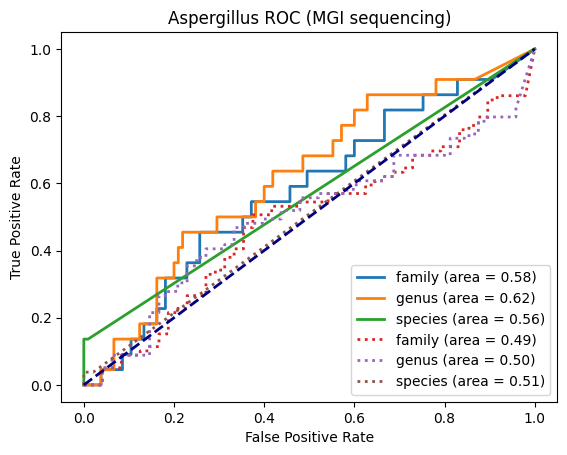

In [34]:
sequence_type = "MGI"
sslevel = 'subsystems_norm_ss.tsv.gz'

aspname = {'family': 'Aspergillaceae', 'genus': 'Aspergillus', 'species': 'Aspergillus campestris'}
#aspname = {'genus': 'Aspergillus', 'family': 'Aspergillaceae'}

plt.figure()

for taxa in aspname:
    df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
    
    merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + ['CS_Aspergillus fumigatus']], how='inner')
    res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
    
    y_true = res['CS_Aspergillus fumigatus']
    y_scores = res[aspname[taxa]]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{taxa} (area = {roc_auc:.2f})')

for taxa in aspname:
    df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
    
    merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals'] + igs + ['CS_Aspergillus fumigatus', 'CS_Aspergillus flavus',  'CS_Aspergillus nidulans',  'CS_Aspergillus niger',  'CS_Aspergillus terreus', 'P12M_6_Aspergillus', 'N12M_Aspergillus fumigatus']], how='inner')
    res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
    
    y_true = res[['CS_Aspergillus fumigatus',  'CS_Aspergillus flavus',  'CS_Aspergillus nidulans',  'CS_Aspergillus niger',  'CS_Aspergillus terreus', 'P12M_6_Aspergillus', 'N12M_Aspergillus fumigatus']].astype(bool).any(axis=1)
    y_scores = res[aspname[taxa]]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, linestyle=':', label=f'{taxa} (area = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Aspergillus ROC ({sequence_type} sequencing)')
plt.legend(loc="lower right")
plt.show()

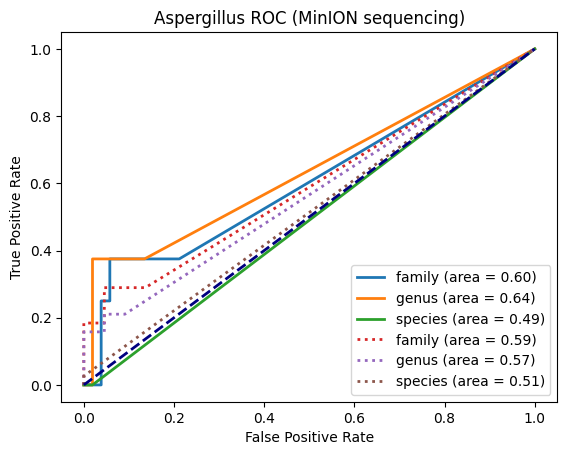

In [15]:
sequence_type = "MinION"
sslevel = 'subsystems_norm_ss.tsv.gz'

aspname = {'family': 'Aspergillaceae', 'genus': 'Aspergillus', 'species': 'Aspergillus campestris'}
#aspname = {'genus': 'Aspergillus', 'family': 'Aspergillaceae'}

plt.figure()

for taxa in aspname:
    df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
    
    merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals', 'CS_Aspergillus fumigatus']], how='inner')
    res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
    
    y_true = res['CS_Aspergillus fumigatus']
    y_scores = res[aspname[taxa]]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{taxa} (area = {roc_auc:.2f})')

for taxa in aspname:
    df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
    
    merged = df[[aspname[taxa]]].join(metadata[['pwCF_ID', 'Sample date', 'Sum of antifungals', 'CS_Aspergillus fumigatus', 'CS_Aspergillus flavus',  'CS_Aspergillus nidulans',  'CS_Aspergillus niger',  'CS_Aspergillus terreus', 'P12M_6_Aspergillus', 'N12M_Aspergillus fumigatus']], how='inner')
    res = merged.sort_values(by=['pwCF_ID', 'Sample date'])
    
    y_true = res[['CS_Aspergillus fumigatus',  'CS_Aspergillus flavus',  'CS_Aspergillus nidulans',  'CS_Aspergillus niger',  'CS_Aspergillus terreus', 'P12M_6_Aspergillus', 'N12M_Aspergillus fumigatus']].astype(bool).any(axis=1)
    y_scores = res[aspname[taxa]]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, linestyle=':', label=f'{taxa} (area = {roc_auc:.2f})')
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Aspergillus ROC ({sequence_type} sequencing)')
plt.legend(loc="lower right")
plt.show()

# Violin plots for Aspergillus abundance

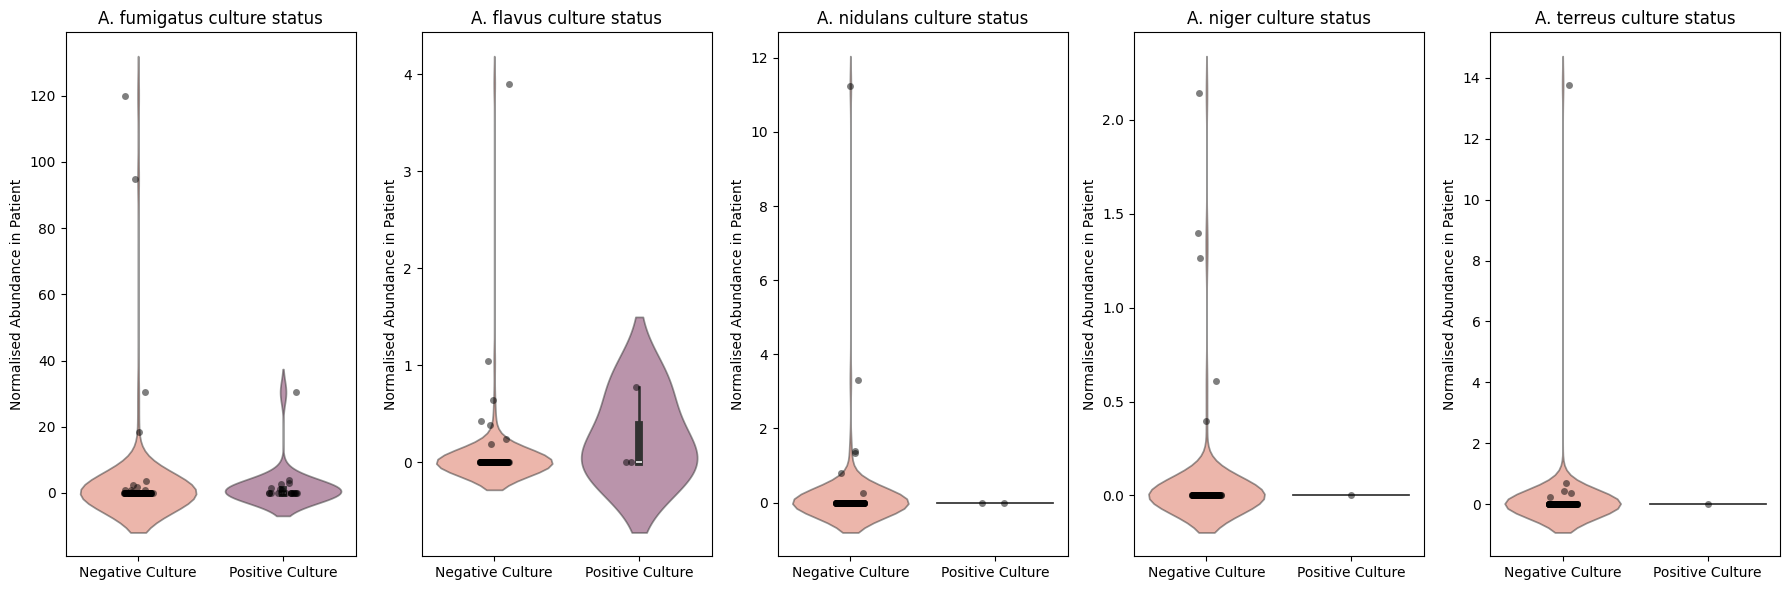

In [35]:

taxa = 'species'
cs = {
    'CS_Aspergillus fumigatus': 'Aspergillus fumigatus',  
    'CS_Aspergillus flavus': 'Aspergillus flavus',  
    'CS_Aspergillus nidulans': 'Aspergillus nidulans',  
    'CS_Aspergillus niger': 'Aspergillus niger',  
    'CS_Aspergillus terreus': 'Aspergillus terreus'
}

cults = cs.keys()
taxas = cs.values()

fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=len(cs), sharex=False, sharey=False)
j = 0
sequence_type = 'MGI'
df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel=sslevel, taxa=taxa, all_taxa=True, verbose=False)
merged = df[taxas].join(metadata[cults], how='inner')

for i, c in enumerate(cs.keys()):
    subset_data = merged[merged[c].notna()]
    g = sns.violinplot(x=c, y=cs[c], data=subset_data, hue=c, palette='rocket_r', alpha=0.5, ax=ax[i], legend=False)
    g = sns.stripplot(x=c, y=cs[c], data=subset_data, color='black', jitter=True, alpha=0.5, ax=ax[i], legend=False)
    g.set_xlabel("")
    g.set_ylabel("Normalised Abundance in Patient")
    g.set_xlim(-0.5, 1.5)
    g.set_xticks(ticks=[0, 1], labels=["Negative Culture", "Positive Culture"])
    g.set_title(f"{c.replace('CS_', '').replace('Aspergillus', 'A.')} culture status")


plt.tight_layout()
plt.show()

In [36]:
for c in df.columns:
    if 'asperg' in c.lower():
        print(c)

Aspergillus aculeatinus
Aspergillus alliaceus
Aspergillus arachidicola
Aspergillus avenaceus
Aspergillus awamori
Aspergillus bombycis
Aspergillus brasiliensis
Aspergillus burnettii
Aspergillus caelatus
Aspergillus calidoustus
Aspergillus campestris
Aspergillus candidus
Aspergillus carbonarius
Aspergillus chevalieri
Aspergillus cristatus
Aspergillus ellipticus
Aspergillus eucalypticola
Aspergillus felis
Aspergillus fijiensis
Aspergillus fischeri
Aspergillus flavus
Aspergillus fumigatiaffinis
Aspergillus fumigatus
Aspergillus glaucus
Aspergillus heteromorphus
Aspergillus hiratsukae
Aspergillus homomorphus
Aspergillus ibericus
Aspergillus lentulus
Aspergillus melleus
Aspergillus mulundensis
Aspergillus nidulans
Aspergillus niger
Aspergillus nomiae
Aspergillus novofumigatus
Aspergillus novoparasiticus
Aspergillus ochraceoroseus
Aspergillus oryzae
Aspergillus parasiticus
Aspergillus pseudocaelatus
Aspergillus pseudonomiae
Aspergillus pseudotamarii
Aspergillus ruber
Aspergillus sclerotialis


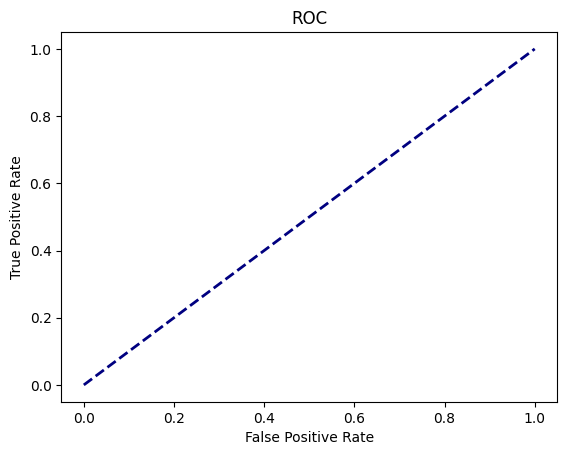

In [37]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC')
plt.show()